In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [2]:
start = datetime.datetime(2016, 11, 1)
end = datetime.datetime(2021, 11, 1)

tickers = ['BTC-USD', 'ETH-USD']

df = web.DataReader(tickers, 'yahoo', start=start, end=end)['Adj Close']
df.tail()

Symbols,BTC-USD,ETH-USD
Date,,
2021-10-28,62227.964844,4414.746582
2021-10-29,61888.832031,4325.650391
2021-10-30,61318.957031,4288.074219
2021-11-01,61004.406250,4324.626953
2021-11-02,63226.402344,4584.798828


In [3]:
BTC = pd.DataFrame()
BTC['Close'] = df['BTC-USD']
BTC.index = pd.to_datetime(BTC.index)
BTC['EWA-12'] = BTC['Close'].ewm(span=12).mean()
BTC['EWA-26'] = BTC['Close'].ewm(span=26).mean()
BTC['MACD'] = BTC['Close'].ewm(span=12).mean() - BTC['Close'].ewm(span=26).mean()
BTC['SIGNAL'] = BTC['MACD'].ewm(span=9).mean()
BTC['RETURN'] = np.log(BTC['Close'] / BTC['Close'].shift(1))
BTC['VOLATILITY'] = BTC['RETURN'].rolling(30).std() * np.sqrt(365 / 30)

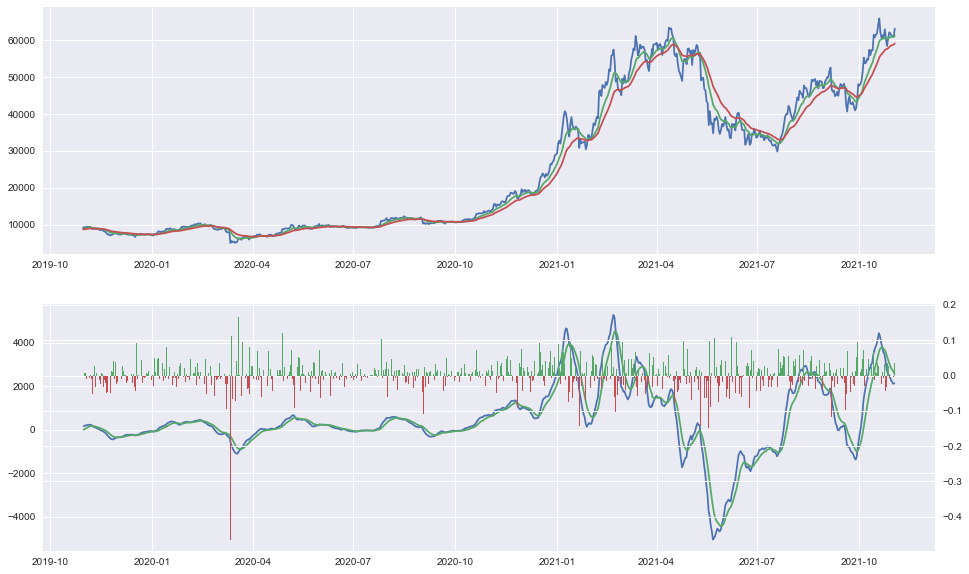

In [4]:
w = 365 * 2

fig, axs = plt.subplots(2, figsize=(16, 10))
axs[0].plot(BTC['Close'][-w:]);
axs[0].plot(BTC['EWA-12'][-w:]);
axs[0].plot(BTC['EWA-26'][-w:]);
axs[1].plot(BTC['MACD'][-w:]);
axs[1].plot(BTC['SIGNAL'][-w:]);
axs3 = axs[1].twinx()
clrs = ['C2' if (x < 0) else 'C1' for x in BTC['RETURN'][-w:] ]
axs3.bar(BTC.index[-w:], BTC['RETURN'][-w:], color=clrs);

In [5]:
ETH = pd.DataFrame()
ETH['Close'] = df['ETH-USD']
ETH.index = pd.to_datetime(ETH.index)
ETH['EWA-12'] = ETH['Close'].ewm(span=12).mean()
ETH['EWA-26'] = ETH['Close'].ewm(span=26).mean()
ETH['MACD'] = ETH['Close'].ewm(span=12).mean() - ETH['Close'].ewm(span=26).mean()
ETH['SIGNAL'] = ETH['MACD'].ewm(span=9).mean()
ETH['RETURN'] = np.log(ETH['Close'] / ETH['Close'].shift(1))
ETH['VOLATILITY'] = ETH['RETURN'].rolling(30).std() * np.sqrt(365 / 30)

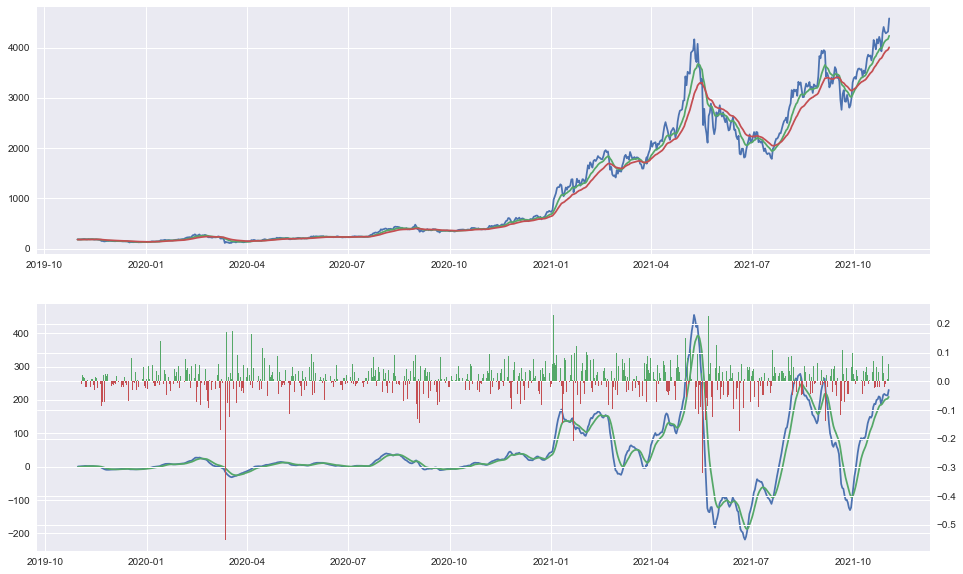

In [6]:
w = 365 * 2

fig, axs = plt.subplots(2, figsize=(16, 10))
axs[0].plot(ETH['Close'][-w:]);
axs[0].plot(ETH['EWA-12'][-w:]);
axs[0].plot(ETH['EWA-26'][-w:]);
axs[1].plot(ETH['MACD'][-w:]);
axs[1].plot(ETH['SIGNAL'][-w:]);
axs3 = axs[1].twinx()
clrs = ['C2' if (x < 0) else 'C1' for x in ETH['RETURN'][-w:] ]
axs3.bar(ETH.index[-w:], ETH['RETURN'][-w:], color=clrs);

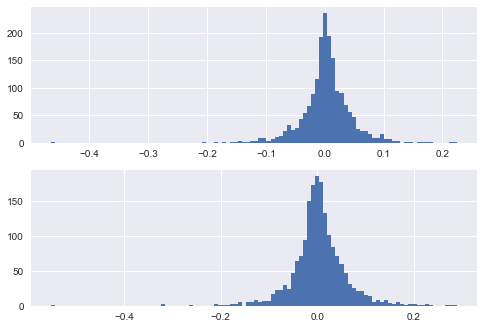

In [7]:
fig, axs = plt.subplots(2)
axs[0].hist(BTC['RETURN'], bins=100);
axs[1].hist(ETH['RETURN'], bins=100);

In [8]:
BTC['RETURN'].tail()

Date
2021-10-28    0.026144
2021-10-29   -0.005465
2021-10-30   -0.009251
2021-11-01   -0.005143
2021-11-02    0.035776
Name: RETURN, dtype: float64

In [9]:
from scipy import stats
stats.normaltest(BTC['RETURN'])

NormaltestResult(statistic=nan, pvalue=nan)

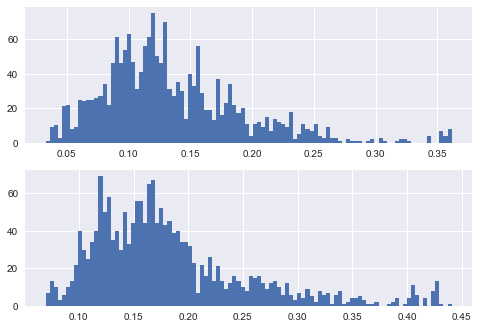

In [10]:
fig, axs = plt.subplots(2)
axs[0].hist(BTC['VOLATILITY'], bins=100);
axs[1].hist(ETH['VOLATILITY'], bins=100);

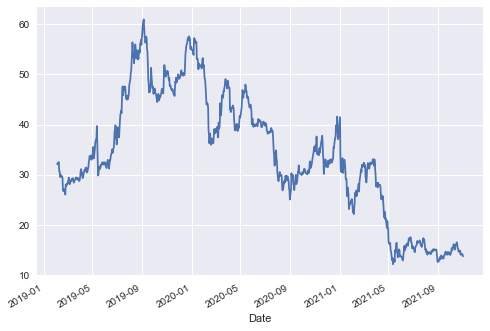

In [11]:
ratio = BTC['Close'][-1000:] / ETH['Close'][-1000:]
ratio.plot();

In [34]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std
    
    # Simulate trading
    # Start with no money and no positions
    balance = np.zeros(len(ratios))
    value = np.zeros(len(ratios))
    countS1 = 0
    countS2 = 0
    for i in range(1, len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            balance[i] = balance[i - 1] + (S1[i] - S2[i] * ratios[i]) # self-financing
            countS1 -= abs(zscore[i]) / 1000
            countS2 += ratios[i] * abs(zscore[i]) / 1000
            #print('Selling Ratio %s %s %s %s'%(balance, ratios[i], countS1, countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] < -1:
            balance[i] = balance[i - 1] - (S1[i] - S2[i] * ratios[i]) # self-financing
            countS1 += abs(zscore[i]) / 1000
            countS2 -= ratios[i] * abs(zscore[i]) / 1000
            #print('Buying Ratio %s %s %s %s'%(balance,ratios[i], countS1, countS2))
        # Clear positions if the z-score between -.75 and .75
        elif abs(zscore[i]) <= 0.5:
            balance[i] = balance[i - 1] + (S1[i] * countS1 + S2[i] * countS2)
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(balance,ratios[i], countS1, countS2))
        else:
            balance[i] = balance[i - 1]
        value[i] = countS1 * S1[i] + countS2 * S2[i] + balance[i]
    return balance, value

In [35]:
n = 365
balance, value = trade(BTC['Close'][-n:], ETH['Close'][-n:], 7, 365//4)

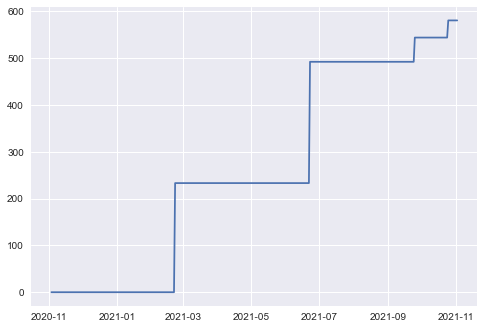

In [36]:
plt.plot(BTC.index[-n:], balance);

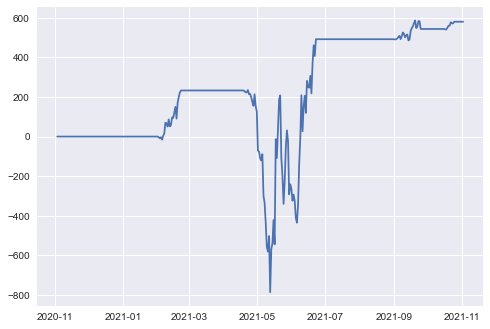

In [37]:
plt.plot(BTC.index[-n:], value);